# Eigenvalue problems

For a square matrix $A$, an **eigenvector** $x$ is a solution to:

$$
Ax = \lambda x \qquad \Longleftrightarrow \qquad  (A - \lambda I)x = 0
$$
for some $x\ne 0$ and some scalar $\lambda$, the **eigenvalue**.

The important thing about eigenvectors is that they make a complicated matrix $A$ **act like a scalar** $\lambda$, which makes it easier to understand.

For a typical $m \times m$ matrix $A$, you will almost always have $m$ eigenvalues $\lambda_1, \ldots, \lambda_m$ and corresponding linearly independent eigenvectors $x_1, \ldots, x_k$.   That allows you to form a **basis of eigenvectors**: you can write *any* vector as a linear combination of eigenvectors, and then anything you want to do with $A$ becomes *easy (scalar) on each term*.

## Computing eigenvalues and eigenvectors

From the second form of the eigen-equation above, we immediately see that for any eigenvalue $\lambda$, the matrix $A - \lambda I$ must be **singular**, which implies that its **determinant is zero**:

$$
\det(A - \lambda I) = 0
$$

If you think a little bit about determinant formulas, which are a sum of terms that multiply one entry from each row and column of the matrix, you'll quickly see that $\det(A - \lambda I)$ is a **polynomial of degree m in λ**, called the **characteristic polynomial of A**.

So, one way to find eigenvalues, which you probably already learned, is to compute this determinant to find the polynomial, and then **calculate the roots of the polyomial**.  Once you have an eigenvalue, finding an eigenvector is relatively easy: it comes from the nullspace of $A - \lambda I$, and can be computed by Gaussian elimination.

However, while this is an easy procedure for $2\times 2$ matrices, it is not so obvious how to carry it out for large matrices, where you would have to find **roots of high-degree polynomials**.   Efficient and accurate solution of eigenproblems is a famously tricky problem in numerical linear algebra, and the modern algorithms are *not obvious*.

Here, we will cheat and use the function `eigen` in Julia's `LinearAlgebra` standard library:

In [1]:
using LinearAlgebra

A = [1.0 2.0
     3.0 4.0]
λ, X = eigen(A)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
2-element Vector{Float64}:
 -0.3722813232690143
  5.372281323269014
vectors:
2×2 Matrix{Float64}:
 -0.824565  -0.415974
  0.565767  -0.909377

Here, our 2x2 matrix has two eigenvalues:

In [2]:
λ

2-element Vector{Float64}:
 -0.3722813232690143
  5.372281323269014

and corresponding eigenvalues given by the *columns* of the matrix $X$:

In [3]:
X

2×2 Matrix{Float64}:
 -0.824565  -0.415974
  0.565767  -0.909377

Let's check that this works fore the first column, denoted `X[:,1]` in Julia, by computing $Ax - \lambda x$:

In [4]:
A * X[:,1] - λ[1] * X[:,1]

2-element Vector{Float64}:
 0.0
 5.551115123125783e-17

Yup, it's zero up to roundoff errors!  (The computer only does arithmetic to 15–16 digits by default.)

These eigenvectors will form a basis for $\mathbb{R}^2$, but they are not orthogonal:

In [5]:
X' * X

2×2 Matrix{Float64}:
  1.0       -0.171499
 -0.171499   1.0

The off-diagonal elements are the dot products of the eigenvectors with each other, and are not even close to zero: they are **not orthogonal**.

## Using eigenvalues and eigenvectors: Matrix powers & exponentials

The key point is the **matrix acts like a scalar λ** when acting on an eigenvector,
for **any operation you might want to do with the matrix**.

For example:

* Matrix *inverses*: $A^{-1} x = \lambda^{-1} x$
* General matrix *powers*: $A^n x = \lambda^n x$
   - These show up in lots of problems, including linear *recurrence equations*.
* Matrix *exponentials*: $e^{A}x = \left(I + A + A^2/2 + A^3/6 + \cdots + A^n/n! + \cdots\right) x = e^{\lambda} x$
  - These are important when solving *systems of differential equations* $\frac{dx}{dt} = Ax$: for any initial condition $x(0)$, the solution is $x(t) = e^{At} x(0)$.
  
For *any* $x$, you expand in the basis of eigenvectors:
$$
x = c_1 x_1 + c_2 x_2 + \cdots + c_m x_m = \sum_k c_k x_k = X c
$$
for some coefficients $c = X^{-1} x$, and then act $A$ on *each term as a scalar*.  For example,
with matrix powers:
$$
A^n x = \sum_k c_k \boxed{ \lambda_k^m}  x_k
$$
multiplies *each term* by $\lambda_k^m$.

This means, for example, that multiplying a random vector by $A$ many times tends towards the largest eigenvector.  For example, with our 2x2 matrix above:

In [6]:
x = randn(2) # a random 2-component vector

2-element Vector{Float64}:
 1.1064255702282437
 0.6604584519709495

In [7]:
y = A^100 * x # should be parallel to x₂

2-element Vector{Float64}:
 5.1264936878916495e72
 1.1207236302712575e73

This should be nearly parallel to $x_2$.  Recall that the eigenvalues were $\lambda_1 \approx -0.37$ and $\lambda_2 \approx 5.4$, so:
$$
x = c_1 x_1 + c_2 x_2 \implies A^{100} x = (-0.37)^{100} c_1 x_1 + (5.4)^{100} c_2 x_2 \approx (5.4)^{100} c_2 x_2 
$$
since the second term is exponentially larger than the first.

Here, we can check that it is parallel to $x_2$ by looking at the ratio of the components:

In [8]:
y[2]/y[1]

2.186140661634507

In [9]:
x₂ = X[:,2] # second eigenvector
x₂[2]/x₂[1]

2.1861406616345076

In [10]:
cross([y; 0], [x₂; 0]) / norm(y)

3-element Vector{Float64}:
  0.0
 -0.0
 -6.366701349055913e-17

Yup, they are parallel!

It should also be that $\Vert A^n x \Vert$ grows nearly exponentially, proportional to $\lambda_2^n$.  Let's plot it:

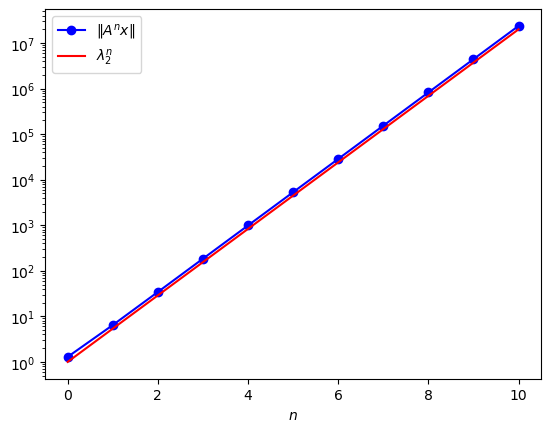

PyObject Text(0.5, 24.0, '$n$')

In [11]:
using PyPlot
semilogy(0:10, [norm(A^n * x) for n=0:10], "bo-")
semilogy(0:10, λ[2] .^ (0:10), "r-")
legend([L"\Vert A^n x \Vert", L"\lambda_2^n"])
xlabel(L"n")

### Example: Cyclic permutations:

Another example is the $4 \times 4$ cyclic permutation matrix $P$

In [12]:
P = [ 0 1 0 0
      0 0 1 0
      0 0 0 1
      1 0 0 0 ]

4×4 Matrix{Int64}:
 0  1  0  0
 0  0  1  0
 0  0  0  1
 1  0  0  0

In [13]:
P * [1,2,3,4]

4-element Vector{Int64}:
 2
 3
 4
 1

In [14]:
P^4 * [1,2,3,4]

4-element Vector{Int64}:
 1
 2
 3
 4

In [15]:
P^4

4×4 Matrix{Int64}:
 1  0  0  0
 0  1  0  0
 0  0  1  0
 0  0  0  1

In [16]:
eigvals(P) # just computes eigenvalues

4-element Vector{ComplexF64}:
    -0.9999999999999997 + 0.0im
 1.2902104469069482e-16 - 1.0000000000000002im
 1.2902104469069482e-16 + 1.0000000000000002im
                    1.0 + 0.0im

Up to roundoff errors, the eigenvalues are $-1, -i, +i, +1$.

This is a consequence of the fact that $P^4 = I$, which means that $\lambda^4 = 1$:

In [17]:
P^4

4×4 Matrix{Int64}:
 1  0  0  0
 0  1  0  0
 0  0  1  0
 0  0  0  1

In [18]:
eigvals(P) .^ 4 # each element to 4th power

4-element Vector{ComplexF64}:
 0.9999999999999987 - 0.0im
 1.0000000000000009 + 5.160841787627796e-16im
 1.0000000000000009 - 5.160841787627796e-16im
                1.0 + 0.0im

### Complex eigenvalues of real matrices

Notice that, even though $P$ is a *real* matrix, its **eigenvalues (and eigenvectors)** can be **complex**.

This isn't too surprising if you think about the connection to roots of polynomials — even for the quadratic equation, you know that *real polynomials can have complex roots*.

If you make a random real matrix, it almost always has some complex roots if the matrix is big enough.  For example:

In [19]:
R = randn(20,20) # a random 20x20 matrix:

20×20 Matrix{Float64}:
  0.829171   0.138794   0.678026   …  -0.91498     0.948123   -0.803583
  2.19259    0.748492   0.414546       0.171528    0.68522     0.223575
  0.816218   0.153332  -0.914678      -1.20477    -0.153085    0.521608
 -1.47155   -1.49438   -0.274829       0.218383    0.0826769  -0.469391
  0.743134  -0.177163   0.313937      -1.24328     0.613885    0.271068
 -0.186778  -0.171095  -1.03668    …   2.46496     2.15091     0.0320823
  0.301177  -0.115305  -0.339294      -0.488035    0.46601    -0.365528
  1.73961    0.323871  -1.09787       -0.503415   -1.14928     1.29621
 -0.792071   0.683768  -0.908675      -1.20089    -0.672091    0.44782
 -0.351495  -0.536343   0.2996        -2.24491     1.40864    -1.52049
 -0.370341   1.21907   -0.896898   …  -0.180509   -0.429355   -0.141925
  0.989002   0.140579   0.300553      -0.914419    0.0226391   0.141268
 -0.793007  -0.101244   0.21641       -1.11298     0.467109    0.575488
  0.281743  -0.593686  -0.147228      -0.05

In [20]:
λ = eigvals(R) # its complex eigenvalues

20-element Vector{ComplexF64}:
    -4.029758270745915 + 0.0im
   -2.6633757669626856 - 1.3053111840992218im
   -2.6633757669626856 + 1.3053111840992218im
   -2.1982876157312465 + 0.0im
   -2.1438324706632796 - 2.3199797501785926im
   -2.1438324706632796 + 2.3199797501785926im
 -0.052050103895014396 - 1.7072423620543062im
 -0.052050103895014396 + 1.7072423620543062im
   0.17696831746269315 - 3.9684099248490288im
   0.17696831746269315 + 3.9684099248490288im
    0.9903843645924151 - 0.4121854874725685im
    0.9903843645924151 + 0.4121854874725685im
     1.469730788006183 - 2.31275995485107im
     1.469730788006183 + 2.31275995485107im
    1.7756728065541905 + 0.0im
     2.195870725270419 - 3.853100900798987im
     2.195870725270419 + 3.853100900798987im
     2.997204454240207 - 2.006535728143899im
     2.997204454240207 + 2.006535728143899im
      3.76663409591321 + 0.0im

One thing to notice is that the complex numbers come in complex-conjugate pairs.  This is *always* the case for real $A$, since
$$
\overline{Ax = \lambda x} = \bar{A} \bar{x} = \bar{\lambda}\bar{x} = A\bar{x}
$$
i.e. $\bar{x}$ is also an eigenvector with eigenvalue $\bar{\lambda}$.

Let's plot the eigenvalues in the complex plane:

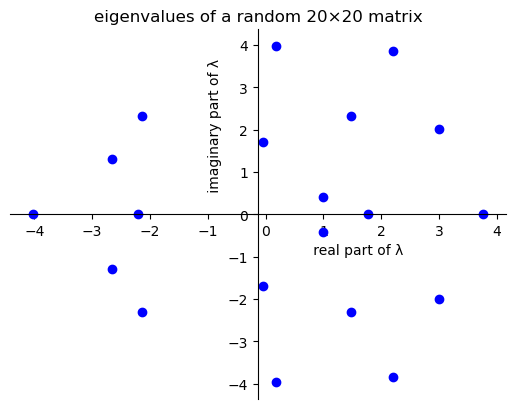

In [21]:
using PyPlot
plot(real(λ), imag(λ), "bo")
xlabel(lpad("real part of λ",60))
ylabel(lpad("imaginary part of λ", 60))
title("eigenvalues of a random 20×20 matrix")


function center_spines(ax)
    ax.spines["left"].set_position("center")
    ax.spines["right"].set_color("none")
    ax.spines["bottom"].set_position("center")
    ax.spines["top"].set_color("none")
    #ax.spines["left"].set_smart_bounds(true)
    #ax.spines["bottom"].set_smart_bounds(true)
    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")
end
center_spines(gca())

### Hermitian/real-symmetric matrics and the discrete Laplacian

As another example, let's construct the famous "discrete Laplacian" matrix $L$.  (You may have seen $-L$ instead, which can be viewed as a finite-difference approximation for $d^2/dx^2$ on a uniform grid.  Here, it turns out to be slightly nicer to flip the sign, which flips the sign of all the eigenvalues.)

$$
L = \begin{pmatrix} 2 & -1 & & & & \\
-1 & 2 & -1 & & & \\
& \ddots & \ddots & \ddots & & \\
& & -1 & 2 & -1 & \\
& & & -1 & 2 & -1 \\
& & & & -1 & 2 \end{pmatrix}
$$
which can be constructed in Julia in a variety of ways, e.g.:

In [22]:
m = 6
L = diagm(-1 => fill(-1,m-1), 0 => fill(2,m), +1 => fill(-1,m-1))

6×6 Matrix{Int64}:
  2  -1   0   0   0   0
 -1   2  -1   0   0   0
  0  -1   2  -1   0   0
  0   0  -1   2  -1   0
  0   0   0  -1   2  -1
  0   0   0   0  -1   2

This is a **real-symmetric tridiagonal matrix** $L = L^T$.  Julia actually has a special type for this sort of matrix, that allows it do computations extra efficiently (it doesn't even store the zero off-diagonal elements):

In [23]:
L = SymTridiagonal(fill(2,m), fill(-1,m-1))

6×6 SymTridiagonal{Int64, Vector{Int64}}:
  2  -1   ⋅   ⋅   ⋅   ⋅
 -1   2  -1   ⋅   ⋅   ⋅
  ⋅  -1   2  -1   ⋅   ⋅
  ⋅   ⋅  -1   2  -1   ⋅
  ⋅   ⋅   ⋅  -1   2  -1
  ⋅   ⋅   ⋅   ⋅  -1   2

The eigenvalues of *any* real-symmetric matrix are very special: they are **always real**: 

In [24]:
eigvals(L)

6-element Vector{Float64}:
 0.1980622641951617
 0.7530203962825329
 1.5549581320873713
 2.4450418679126287
 3.2469796037174667
 3.8019377358048385

Moreover, the eigenvectors are **orthogonal** (and can be normalized to **orthonormal**):

In [25]:
Q = eigvecs(L)

6×6 Matrix{Float64}:
 0.231921  -0.417907   0.521121  -0.521121  -0.417907   0.231921
 0.417907  -0.521121   0.231921   0.231921   0.521121  -0.417907
 0.521121  -0.231921  -0.417907   0.417907  -0.231921   0.521121
 0.521121   0.231921  -0.417907  -0.417907  -0.231921  -0.521121
 0.417907   0.521121   0.231921  -0.231921   0.521121   0.417907
 0.231921   0.417907   0.521121   0.521121  -0.417907  -0.231921

Let's check that they are orthogonal: $Q^T Q \approx I$:

In [26]:
Q' * Q

6×6 Matrix{Float64}:
  1.0           3.2e-16      -3.23485e-16  …  -6.06815e-17  -1.26907e-16
  3.2e-16       1.0           1.63628e-16      1.09586e-16   8.61728e-17
 -3.23485e-16   1.63628e-16   1.0             -4.28431e-17  -4.34141e-17
 -1.92391e-16  -2.27856e-17  -1.05864e-16     -1.0623e-16   -7.7364e-17
 -6.06815e-17   1.09586e-16  -4.28431e-17      1.0          -2.34469e-16
 -1.26907e-16   8.61728e-17  -4.34141e-17  …  -2.34469e-16   1.0

It's a little hard to see because of the roundoff errors.  Let's round to 3 decimal places:

In [27]:
round.(Q' * Q, digits=3)

6×6 Matrix{Float64}:
  1.0   0.0  -0.0  -0.0  -0.0  -0.0
  0.0   1.0   0.0  -0.0   0.0   0.0
 -0.0   0.0   1.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0   1.0  -0.0  -0.0
 -0.0   0.0  -0.0  -0.0   1.0  -0.0
 -0.0   0.0  -0.0  -0.0  -0.0   1.0

Let's try it for a random real-symmetric matrix:

$$
B = R + R^T
$$

In [28]:
B = R + R'

20×20 Matrix{Float64}:
  1.65834     2.33138     1.49424    …  -0.22269    -0.261395  -0.548495
  2.33138     1.49698     0.567878       1.17445     1.58359    0.841074
  1.49424     0.567878   -1.82936       -2.08445    -1.97305    0.802223
 -0.873223   -2.5189     -0.234729      -0.466553    1.98014   -0.757998
  1.19066    -1.5483      1.26955       -3.18594     1.4984    -0.443326
 -1.28653    -0.70039     0.740466   …   1.43708     3.38325   -0.679315
  1.70158    -0.598096   -0.780981       1.26355     0.222589  -0.101874
  1.0822      1.0677     -0.795777      -1.73173    -1.37277    0.291422
  0.100375    1.97324    -0.942124      -1.77077    -1.75298    0.469773
 -2.21561    -0.0290779   0.133419      -1.01377     1.71847   -1.6003
  0.950668    3.11415    -0.0590488  …  -0.0276943  -0.692113   0.181601
 -0.0765708   1.70557     0.651119       0.942239   -0.81868    0.0588557
  1.5453     -0.70579     0.0573533     -1.9466      1.0038     1.38634
  0.963923    0.535501    0.71

In [29]:
eigvals(B)

20-element Vector{Float64}:
 -9.885815419012882
 -9.084302010408306
 -6.843285604985337
 -5.942971471336738
 -4.7145012740161105
 -3.6586794713705375
 -2.5987759869356073
 -2.125904297844215
 -0.8883340910207597
  0.5950921105698613
  1.4203119332808172
  1.8872687001818484
  2.3827569043089762
  3.2628973805220824
  4.577517156826758
  6.138927327909758
  7.186237946968724
  7.649004117817263
  8.873524934813709
 12.281154377914909

They are all real numbers, but they are not all positive!

$L$ must be special in *another* way!

### Positive-definite matrices and the discrete Laplacian

In fact, not only were the eigenvalues real, but they were actually **all positive**.

A real-symmetric (or Hermitian) matrix with *positive* real eigenvalues is called **positive definite**.

(The matrix $-L$ has all-negative eigenvalues, which is called **negative definite**.)

In [30]:
isposdef(L) # check positive-definiteness

true

Positive-definiteness of $L$ is no accident, because it can be factored as a product of two "difference matrices" in a *very special* form:

$$
L = \underbrace{\begin{pmatrix} 2 & -1 & & & \\
-1 & 2 & -1 & & \\
& \ddots & \ddots & \ddots & \\
& & -1 & 2 & -1 \\
& & & -1 & 2  \end{pmatrix}}_{m \times m}
= D^T D = \\
-
\underbrace{\begin{pmatrix} -1 & 1 & & & \\
 & -1 & 1 & & \\
&  & \ddots & \ddots & & \\
& & & -1 & 1 &  \\
& & &  & -1 & 1 \end{pmatrix}}_{m \times (m+1) \mbox{ matrix } -D^T}
\underbrace{\begin{pmatrix} 1 & & & & & \\
-1 & 1 & & & & \\
& \ddots & \ddots & & & \\
& & -1 & 1 &  & \\
& &  & -1 & 1 \\
& & &  & -1 \end{pmatrix}}_{(m+1) \times m \mbox{ matrix } D}
$$

Let's check:

In [31]:
D = diagm(m+1, m, -1 => fill(-1, m), 0 => fill(1, m))

7×6 Matrix{Int64}:
  1   0   0   0   0   0
 -1   1   0   0   0   0
  0  -1   1   0   0   0
  0   0  -1   1   0   0
  0   0   0  -1   1   0
  0   0   0   0  -1   1
  0   0   0   0   0  -1

In [32]:
D'D

6×6 Matrix{Int64}:
  2  -1   0   0   0   0
 -1   2  -1   0   0   0
  0  -1   2  -1   0   0
  0   0  -1   2  -1   0
  0   0   0  -1   2  -1
  0   0   0   0  -1   2

In [33]:
D'D == L

true

It is easy to see that *any* matrix $A = B^T B$ for *any* real $B$ must have eigenvalues $
\lambda \ge 0$.

It is clearly real-symmetric so its eigenvalues and eigenvalues are real.  If $Ax = \lambda x$, then
$$
x^T A x = x^T B^T B x = (Bx)^T (Bx) = \Vert Bx \Vert^2 = \lambda x^T x = \lambda \Vert x \Vert^2
$$
Hence
$$
\lambda = \frac{x^T A x}{x^T x} = \frac{\Vert Bx \Vert^2}{ \Vert x \Vert^2} \ge 0
$$
which is obviously $\ge 0$.  Any such matrix $A$ is **positive semidefinite**.

For it to be **positive definite**, i.e. $\lambda > 0$ (not just $\ge 0$), we must have $Bx \ne 0$ for any $x \ne 0$: **B must be full column rank (independent columns)**.

In the case above, it is obvious that $D$ has rank $m$ ($m$ independent columns).  For example, you can see this because $D^T$ is upper-triangular with $m$ nonzero pivots on the diagonal.